In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
# un volta caricato il file zip su colab
from zipfile import ZipFile

with ZipFile('/content/PennFudanPed.zip', 'r') as zip:
  zip.extractall()
  print('Done')

Done


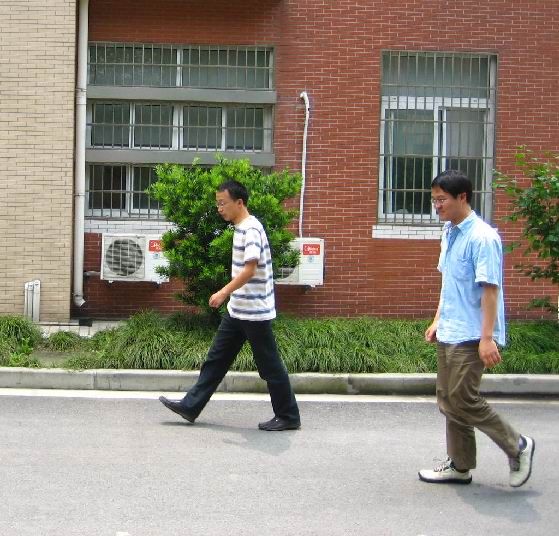

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

# definizione della classe per lavorare col dataset

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FC1B3362D50>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 25976, done.
remote: Counting objects: 100% (3445/3445), done.
remote: Compressing objects: 100% (930/930), done.
remote: Total 25976 (delta 2587), reused 3186 (delta 2450), pack-reused 22531
Receiving objects: 100% (25976/25976), 34.73 MiB | 13.26 MiB/s, done.
Resolving deltas: 100% (19286/19286), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:16  lr: 0.000090  loss: 1.2774 (1.2774)  loss_classifier: 0.7570 (0.7570)  loss_box_reg: 0.4809 (0.4809)  loss_objectness: 0.0327 (0.0327)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 1.2777  data: 0.2187  max mem: 2563
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.000936  loss: 0.8054 (0.8311)  loss_classifier: 0.4945 (0.4814)  loss_box_reg: 0.3186 (0.3246)  loss_objectness: 0.0155 (0.0198)  loss_rpn_box_reg: 0.0053 (0.0054)  time: 0.5930  data: 0.0292  max mem: 3200
Epoch: [0]  [20/60]  eta: 0:00:21  lr: 0.001783  loss: 0.5546 (0.6512)  loss_classifier: 0.2403 (0.3451)  loss_box_reg: 0.2855 (0.2833)  loss_objectness: 0.0140 (0.0186)  loss_rpn_box_reg: 0.0029 (0.0042)  time: 0.5029  data: 0.0092  max mem: 3200
Epoch: [0]  [30/60]  eta: 0:00:15  lr: 0.002629  loss: 0.4630 (0.5717)  loss_classifier: 0.1321 (0.2678)  loss_box_reg: 0.2603 (0.2837)  loss_objectness: 0.0101 (0.0152)  loss_rpn_box_reg: 0.0030 (0.0050)  time: 0.4967  data: 0.0084  max mem: 3200
Epoch: [

torch.Size([3, 976, 976])
tensor([679.6736, 492.3434, 878.8525, 868.6509], device='cuda:0')
tensor([284.9537, 500.5923, 445.2514, 833.1980], device='cuda:0')
tensor([ 60.4623, 494.8082, 246.4808, 846.1364], device='cuda:0')
tensor([455.4423, 503.6166, 675.6321, 922.5096], device='cuda:0')
tensor([737.3856, 453.6957, 756.7466, 526.3883], device='cuda:0')


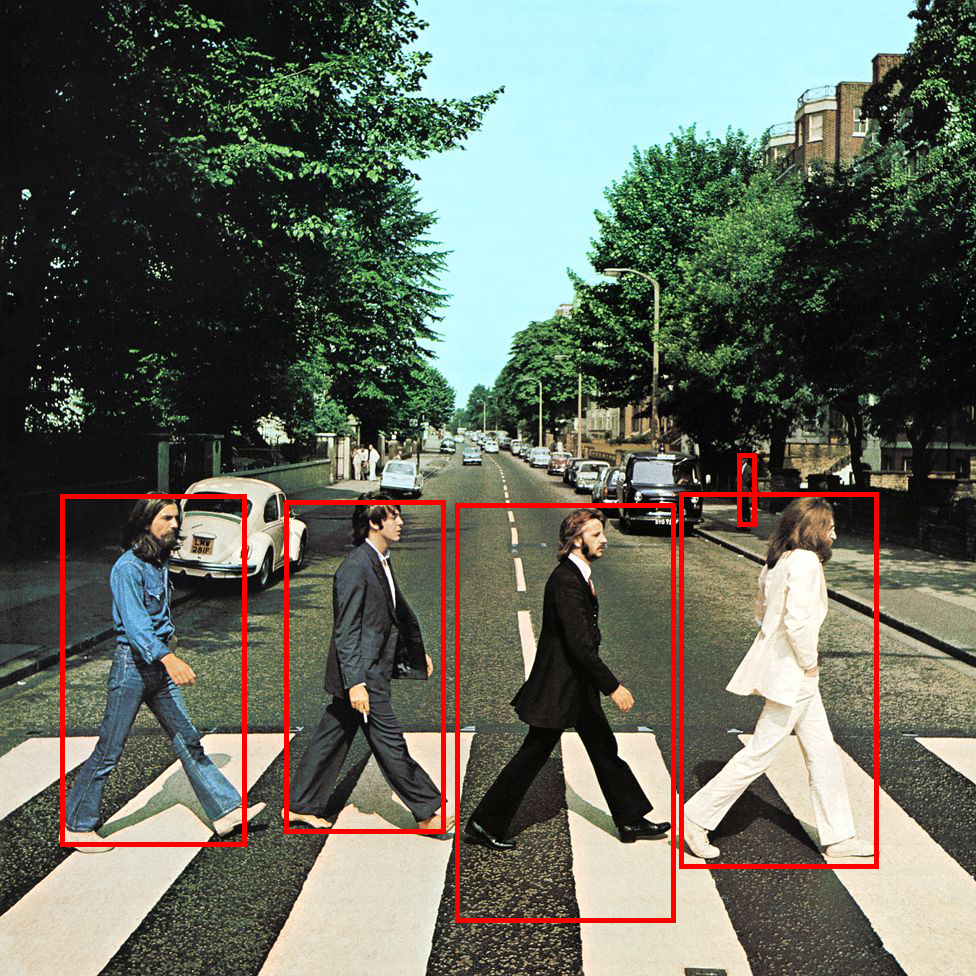

In [ ]:
# img, _ = dataset_test[0]

from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import torchvision.transforms as T
img = Image.open('abbey-road-cover.jpg').convert('RGB')
preprocess = T.ToTensor()

x = preprocess(img)
print(x.shape)

draw = ImageDraw.Draw(img)

model.eval()
with torch.no_grad():
    prediction = model([x.to(device)])

for box in prediction[0]['boxes']:
  print(box)
  draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=5)

Image.fromarray(preprocess(img).mul(255).permute(1, 2, 0).byte().numpy())
# source_img.save(out_file, "JPEG")

In [ ]:
torch.save(model.state_dict(), 'weights.pth')

In [ ]:
prediction

[{'boxes': tensor([[ 60.5348,  34.3909, 195.7028, 323.6419],
          [276.3357,  22.9942, 290.8497,  73.8018]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9981, 0.4037], device='cuda:0')}]